In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_decision_regions
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import scipy.io
import scipy.stats as stats
import statsmodels.api as sm

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard import notebook

In [2]:
import time 
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat        
import matplotlib.pyplot as plt     
import numpy as np                 
import cv2   
import tensorflow as tf

In [12]:
train_path: 'E:\\OneDrive\\OneDrive - Queensland University of Technology\\QUT\\2022\\Semester 1\\CAB420\\Assignment 1B\\ipynb script'
test_path:  'E:\\OneDrive\\OneDrive - Queensland University of Technology\\QUT\\2022\\Semester 1\\CAB420\\Assignment 1B\\ipynb script'

In [13]:
def load_data(train_path, test_path):

    # load files
    train = loadmat(train_path)
    test = loadmat(test_path)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    train_X = np.transpose(train['train_X'], (3, 0, 1, 2)) / 255.0
    train_Y = train['train_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    train_Y[train_Y == 10] = 0
    train_Y = np.reshape(train_Y, -1)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    test_X = np.transpose(test['test_X'], (3, 0, 1, 2)) / 255.0
    test_Y = test['test_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    test_Y[test_Y == 10] = 0
    test_Y = np.reshape(test_Y, -1)

    # return loaded data
    return train_X, train_Y, test_X, test_Y

In [23]:
train_X, train_Y, test_X, test_Y = load_data('CAB420_Assessment_1B_Data\\Q1\\q1_train.mat', 'CAB420_Assessment_1B_Data\\Q1\\q1_test.mat')

In [24]:
# check shape of data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1000, 32, 32, 3)
(1000,)
(10000, 32, 32, 3)
(10000,)


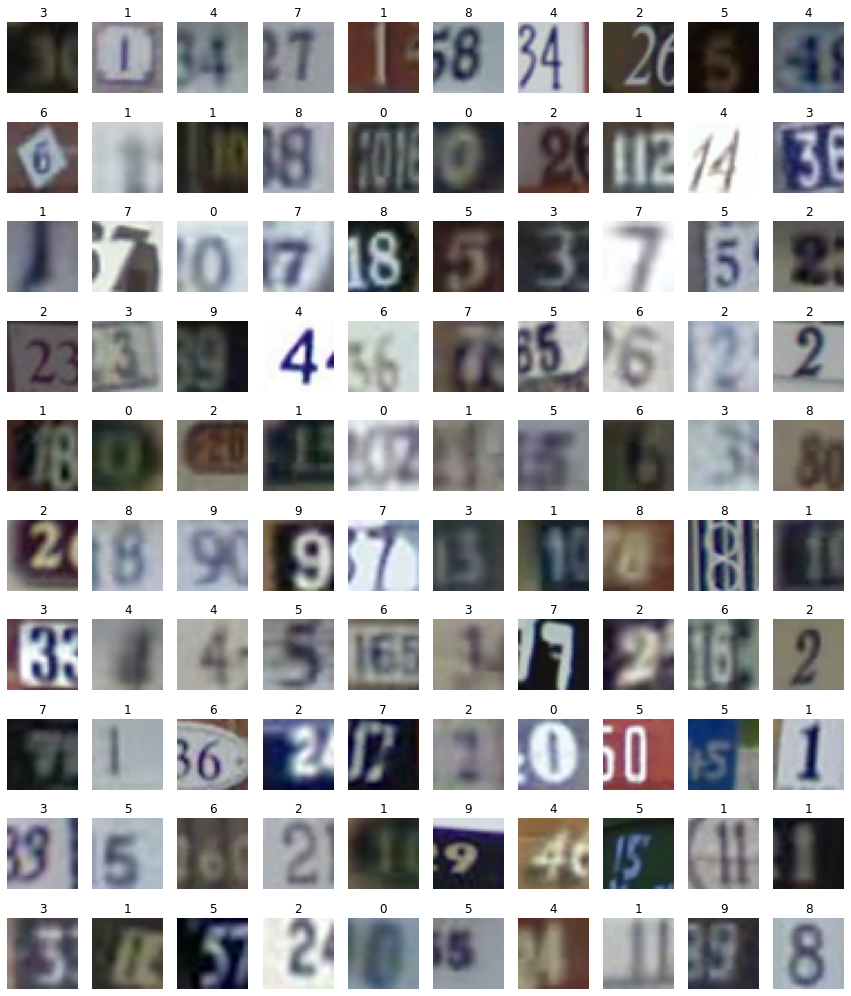

In [25]:
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1)
        ax.imshow(x[i,:])
        ax.set_title(y[i])
        ax.axis('off')
        
plot_images(train_X, train_Y)   

In [26]:
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

train_X_v = vectorise(train_X)
#train_Y_v = vectorise(train_Y)
test_X_v = vectorise(test_X)
#test_Y_v = vectorise(test_Y)

In [27]:
print(train_X_v.shape)
print(test_X_v.shape)

(1000, 3072)
(10000, 3072)


In [28]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    
    test_pred_time_start = time.process_time()
    pred = model.predict(X_test)
    test_pred_time_stop = time.process_time()
    #print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))
    #print('Test Accuracy Score: ' +accuracy_score(Y_test, pred))
    print('Test Accuracy Score: ' + str((accuracy_score(test_Y, pred)*100)))
    print('Test time (in sec): ' +str((test_pred_time_stop-test_pred_time_start)))

Test Accuracy Score: 35.620000000000005
Test time (in sec): 32.734375
Evaluation Time (in sec): 5.9375


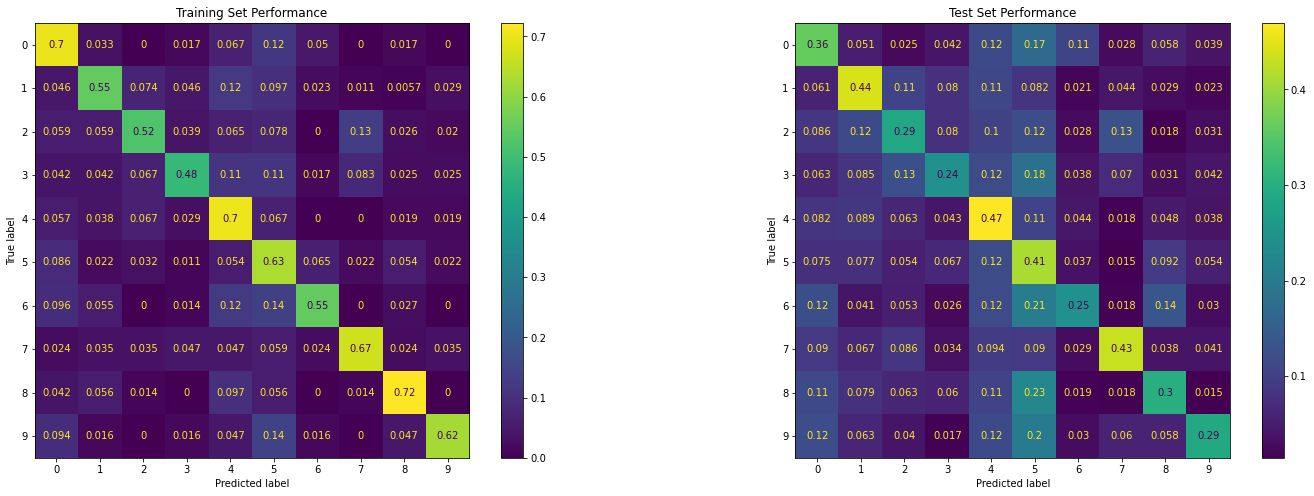

In [29]:
svm = SVC(class_weight='balanced')
eval_model_time_start = time.process_time()
svm_fit = svm.fit(train_X_v, train_Y)
eval_model_time_stop = time.process_time()
eval_model(svm, train_X_v, train_Y, test_X_v, test_Y)
print('Evaluation Time (in sec): ' +str(eval_model_time_stop-eval_model_time_start))

In [33]:
def get_model():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='CNN_Model_Without_Augmentation')
    
    return model_cnn

In [34]:
model_cnn = get_model()

cnn_time_start = time.process_time()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(train_X, train_Y,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.2, verbose=True)
cnn_time_stop = time.process_time()

model_cnn.summary()

Epoch 1/100
25/25 [==============================] - 2s 59ms/step - loss: 2.2816 - accuracy: 0.1612 - val_loss: 2.2400 - val_accuracy: 0.1600
Epoch 2/100
25/25 [==============================] - 1s 54ms/step - loss: 2.2562 - accuracy: 0.1838 - val_loss: 2.2276 - val_accuracy: 0.1650
Epoch 3/100
25/25 [==============================] - 1s 52ms/step - loss: 2.2369 - accuracy: 0.1937 - val_loss: 2.2024 - val_accuracy: 0.1600
Epoch 4/100
25/25 [==============================] - 1s 52ms/step - loss: 2.2156 - accuracy: 0.2113 - val_loss: 2.1930 - val_accuracy: 0.1800
Epoch 5/100
25/25 [==============================] - 1s 20ms/step - loss: 2.1703 - accuracy: 0.2138 - val_loss: 2.1434 - val_accuracy: 0.2150
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 2.1052 - accuracy: 0.2500 - val_loss: 2.1002 - val_accuracy: 0.2550
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 2.0216 - accuracy: 0.3212 - val_loss: 2.0628 - val_accuracy: 0.3300
Epoch 

In [36]:
test_scores = model_cnn.evaluate(test_X, test_Y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

313/313 - 2s - loss: 3.0025 - accuracy: 0.7041 - 2s/epoch - 5ms/step
Test loss: 3.002509355545044
Test accuracy: 0.7041000127792358


In [37]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 4, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    plt.title('Training Performance')
    ax.legend()

    ax = fig.add_subplot(1, 4, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title('Training Performance')
    ax.legend();
    
    train_time_start = time.process_time()
    pred = model.predict(x_test);
    train_time_stop = time.process_time()
    train_time = train_time_stop-train_time_start
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 4, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    plt.title('Confusion Matrix')
    
    ax = fig.add_subplot(1, 4, 4)
    ax.hist(y_test, bins=len(np.diagonal(cm)), rwidth=0.95)
    ax.plot(np.diagonal(cm))
    plt.title('Distribution of Class Values')
    
    print('Training time (in Sec): ' +str(train_time_stop-train_time_start))

Training time (in Sec): 6.953125
Evaluation Time (in sec): 191.890625


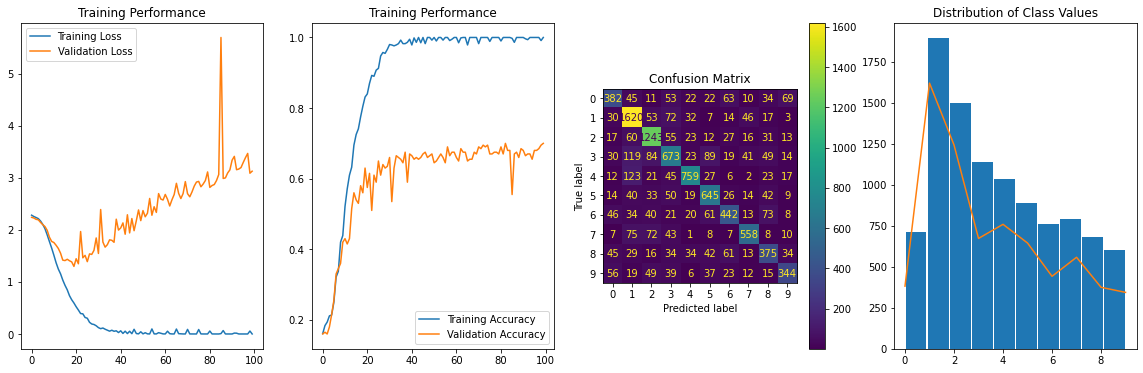

In [38]:
plot_training(history_cnn, model_cnn, test_X, test_Y)
print('Evaluation Time (in sec): ' +str(cnn_time_stop-cnn_time_start))

In [39]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.025),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

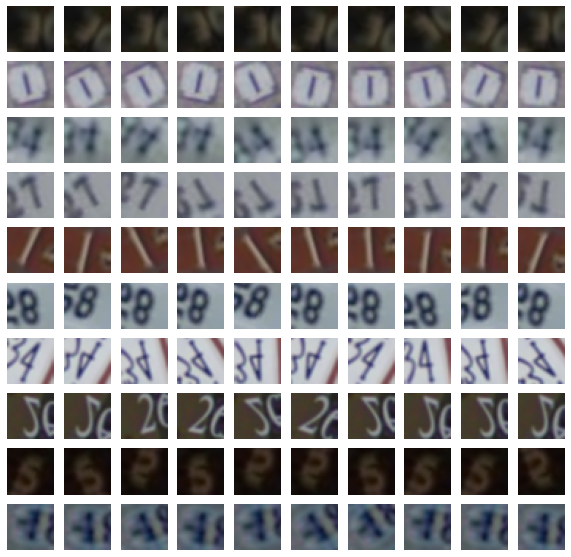

In [40]:
fig = plt.figure(figsize=[10, 10])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(train_X[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [41]:
def get_model_augment():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    augmented = data_augmentation(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(augmented)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model_cnn_aug = keras.Model(inputs=inputs, outputs=outputs, name='CNN_Model_With_Augmentation')
    
    return model_cnn_aug

In [42]:
model_cnn_aug = get_model_augment()

aug_time_start = time.process_time()
model_cnn_aug.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

history_cnn_aug = model_cnn_aug.fit(train_X, train_Y,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.2, verbose=True)

aug_time_stop = time.process_time()

Epoch 1/100
25/25 [==============================] - 2s 35ms/step - loss: 2.2731 - accuracy: 0.1813 - val_loss: 2.2175 - val_accuracy: 0.2050
Epoch 2/100
25/25 [==============================] - 1s 28ms/step - loss: 2.2601 - accuracy: 0.1675 - val_loss: 2.2087 - val_accuracy: 0.1600
Epoch 3/100
25/25 [==============================] - 1s 29ms/step - loss: 2.2556 - accuracy: 0.1813 - val_loss: 2.2229 - val_accuracy: 0.1800
Epoch 4/100
25/25 [==============================] - 1s 27ms/step - loss: 2.2458 - accuracy: 0.1825 - val_loss: 2.2390 - val_accuracy: 0.1600
Epoch 5/100
25/25 [==============================] - 1s 27ms/step - loss: 2.2401 - accuracy: 0.1875 - val_loss: 2.2191 - val_accuracy: 0.1700
Epoch 6/100
25/25 [==============================] - 1s 28ms/step - loss: 2.2226 - accuracy: 0.1937 - val_loss: 2.1921 - val_accuracy: 0.2300
Epoch 7/100
25/25 [==============================] - 1s 28ms/step - loss: 2.1846 - accuracy: 0.2113 - val_loss: 2.1860 - val_accuracy: 0.2050
Epoch 

In [44]:
model_cnn_aug.summary()

Model: "CNN_Model_With_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                   

In [43]:
test_scores = model_cnn_aug.evaluate(test_X, test_Y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

313/313 - 2s - loss: 1.5970 - accuracy: 0.6038 - 2s/epoch - 5ms/step
Test loss: 1.5969513654708862
Test accuracy: 0.6037999987602234


Training time (in Sec): 6.625
Evaluation Time (in sec): 218.5


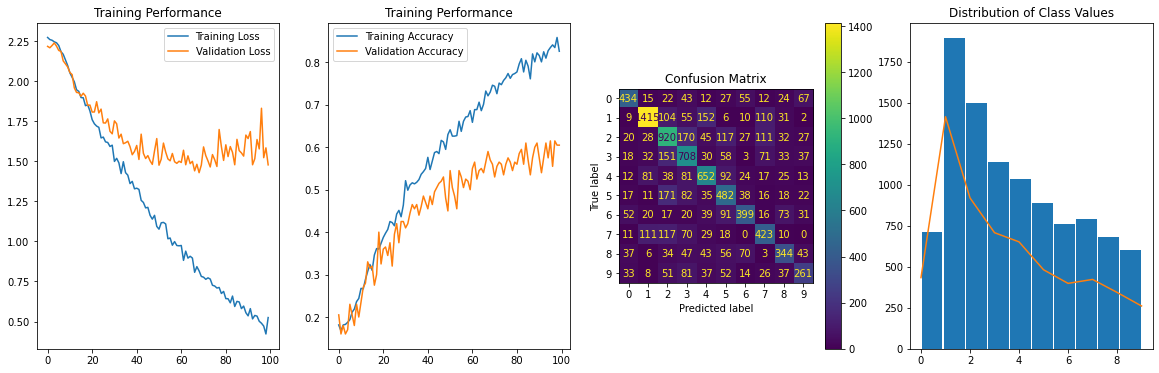

In [45]:
plot_training(history_cnn_aug, model_cnn_aug, test_X, test_Y)
print('Evaluation Time (in sec): ' +str(aug_time_stop-aug_time_start))

In [46]:
model = keras.models.load_model('vgg_2stage_CIFAR_small.h5')

x = layers.Dense(64, activation='relu')(model.layers[-6].output)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(10)(x)

new_model = keras.Model(inputs=model.input, outputs=outputs, name='VGG_CIFAR-10_Small')

new_model.summary()

Model: "VGG_CIFAR-10_Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 8)         584       
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 8)        32        
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 spatial_dropout2d_20 (Spati  (None, 32, 32, 8)        0         
 alDropout2D)                                   

In [47]:
vgg_time_start = time.process_time()
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history_vgg = new_model.fit(train_X, train_Y,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.2, verbose=True)

vgg_time_stop = time.process_time()

Epoch 1/100
25/25 [==============================] - 2s 43ms/step - loss: 2.3435 - accuracy: 0.1875 - val_loss: 2.1149 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 1s 35ms/step - loss: 1.8241 - accuracy: 0.3625 - val_loss: 1.8785 - val_accuracy: 0.3300
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 1.3833 - accuracy: 0.5400 - val_loss: 1.4795 - val_accuracy: 0.5400
Epoch 4/100
25/25 [==============================] - 1s 32ms/step - loss: 1.0217 - accuracy: 0.6888 - val_loss: 1.3387 - val_accuracy: 0.5450
Epoch 5/100
25/25 [==============================] - 1s 32ms/step - loss: 0.7792 - accuracy: 0.7638 - val_loss: 1.3396 - val_accuracy: 0.5800
Epoch 6/100
25/25 [==============================] - 1s 33ms/step - loss: 0.5887 - accuracy: 0.8338 - val_loss: 1.1412 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================] - 1s 32ms/step - loss: 0.4565 - accuracy: 0.8662 - val_loss: 1.0834 - val_accuracy: 0.6950
Epoch 

In [48]:
test_scores = new_model.evaluate(test_X, test_Y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

313/313 - 2s - loss: 2.1512 - accuracy: 0.7021 - 2s/epoch - 8ms/step
Test loss: 2.1511714458465576
Test accuracy: 0.7020999789237976


Training time (in Sec): 12.03125
Evaluation Time (in sec): 445.296875


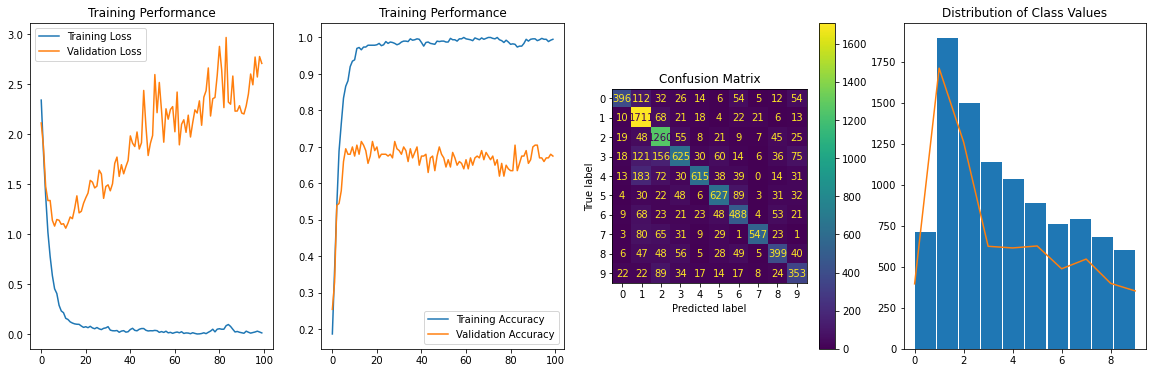

In [49]:
plot_training(history_vgg, new_model, test_X, test_Y)
print('Evaluation Time (in sec): ' +str(vgg_time_stop-vgg_time_start))